In [ ]:
import pandas as pd
import requests
import numpy as np
import unidecode
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from pathlib import Path
import json
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,r2_score, mean_squared_error, roc_auc_score


# Part 0: A class to handle GraphQL queries

In [884]:

class GraphqlQuery:
    def __init__(self, contents : dict[str : list[str]], url : str):
        self._contents = {}
        self.add(contents)
        self.url = url
    
    #method to add further tables and/or columns to the current query
    def add(self, new_contents : dict[str : list[str]]):
        
        #validate passed arguments
        if not isinstance(new_contents, dict):
            raise ValueError("Contents must be passed as dictionary")
        
        for key, val in new_contents.items() :
            if not isinstance(key, str):
                raise ValueError("Table arguments must be passed as strings")
            if not isinstance(val, list):
                raise ValueError("Set of columns must be a list")
            if not all(isinstance(column, str) for column in val):
                raise ValueError("Column arguments must be passed as strings")
            
        for table, columns in new_contents.items():
            if table not in self._contents:
                self._contents[table] = columns
            else:
                self._contents[table].extend(columns)

    #property to store current contents od query in dict format
    @property
    def contents(self):
        return self._contents
    
    #property to store finished query in graphql format
    @property
    def query(self):
        query_str =  ["query Myquery {"]
        for index, (table, columns) in enumerate(self._contents.items()):
            subquery = []
            subquery.append(table)
            subquery.append('{')
            subquery.extend(columns)
            query_str.extend(subquery)
            if index != 0: query_str +="}"
        query_str +="}}"
        
        return " ".join(query_str)
    
    def __str__(self):
        return self._query
     
    @classmethod
    def select(cls, contents : dict[str : list[str]]):
        return cls(contents)

    #method to perform get request to graphql api
    def get_data(self):
        body = {"query" : self.query}
        try:
            response = requests.post(self.url, json=body,timeout=180)
            response.raise_for_status()
            data = response.json()
            return pd.json_normalize(data['data'][list(self._contents)[0]])
        except json.JSONDecodeError as e:
            print(f"JSON decode error: {e}")
            with open("bad_response_snippet.txt", "w", encoding="utf-8") as f:
                f.write(response.text)
            print("Saved response to bad_response_snippet.txt")
        except Exception as e:
                print(f"Error fetching data: {e}")


# Part 1: Data Preparation

In this section the GraphQL API for NBA statistics is queried for player and team information via GraphqlQuery class. Additional data manipulation steps include:  
- Elimination of unwanted characters and conversion of string formats in player names (e.g. change "ć" to "c") in order to avoid problems with merges.
- Mapping of team abbreviations as these are not consistent in the API tables *teams* and *playerPerGame*.
- Merging of both tables into one comprehensive dataframe containing all necessary information.

***As of 20.10.2025, the GraphQL API stopped working. We are therefore forced to substitute the data therein by a flatfile, which was also downloaded from Kaggle.***

The goal of this section, however, remains the same. That is, to create a single dataframe containing all necessary player statistics for the training of our models, plus our target columns, with All Star and MVP data. 

In [885]:
# url = 'https://nbaapi.com/graphql/'

# #set down tables and columns to query from nbaapi
# query_teams = {
#     'team' :
#     ['teamName','teamAbbr', 'season', 'wins']
#     }

# query_players = {
#     'playerPerGame' : 
#     ['playerName', 'team', 'age', 'season', 'games', 'minutesPg', 'points', 'ftPercent', 'assists', 'totalRb', 'steals', 'turnovers', 'blocks']
#     }

# #define Graphqlquery objects
# player_data = GraphqlQuery(query_players, url)
# team_data = GraphqlQuery(query_teams, url)

# #get data from the api and store it in respective dataframes
# player_stats = player_data.get_data()
# team_stats = team_data.get_data()

# #replace "*" and handle string format of player names
# team_stats.teamName = team_stats.teamName.str.replace('*', '')

# player_stats.playerName = player_stats.playerName.str.replace('*', '')
# player_stats.playerName = player_stats.playerName.apply(unidecode.unidecode)

# player_stats = player_stats[player_stats.team != 'TOT']

#set down team abbreviations that need to be changed
team_names = {
    'BRK' : 'NJN',
    'NOP' : 'NOH',
    'CHO' : 'CHA',
    'SEA' : 'OKC',
    'NOK' : 'CHA',
    'CHH' : 'CHA',
    'VAN' : 'MEM',
    'WSB' : 'WAS'
}
# player_stats = player_stats.replace({'team' : team_names})

# #merge player and team statistics into one dataframe
# player_stats = player_stats.merge(
#     team_stats,
#     how='inner',
#     left_on=['season', 'team'],
#     right_on=['season', 'teamAbbr']
# ).drop(['teamAbbr'], axis=1)

# player_stats.head()

In [886]:
#read data from NBA stats flatfile and rename necessary columns 
cols = ['Player', 'Year', 'Age', 'Team', 'G', 'MP',
       'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS']
player_stats = pd.read_csv("NBA Player Stats and Salaries_2000-2025.csv", usecols=cols)

#rename columns to match column names of dataframe extracted from GraphQL API, in preparation for merges in next cell
player_stats = player_stats.rename(
    columns={'Player': 'playerName', 'Year' : 'season', 'Team' : 'team'}
)

player_stats.head()

,playerName,season,Age,team,G,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS
0,Shaquille O'Neal,2000,27,LAL,79,40.0,0.574,0.000,0.575,0.574,0.524,13.6,3.8,0.5,3.0,2.8,3.2,29.7
1,Kevin Garnett,2000,23,MIN,81,40.0,0.497,0.370,0.504,0.507,0.765,11.8,5.0,1.5,1.6,3.3,2.5,22.9
2,Alonzo Mourning,2000,29,MIA,79,34.8,0.551,0.000,0.553,0.551,0.711,9.5,1.6,0.5,3.7,2.7,3.9,21.7
3,Juwan Howard,2000,26,WAS,82,35.5,0.459,0.000,0.462,0.459,0.735,5.7,3.0,0.8,0.3,2.7,3.6,14.9
4,Scottie Pippen,2000,34,POR,82,33.5,0.451,0.327,0.506,0.501,0.717,6.3,5.0,1.4,0.5,2.5,2.5,12.5


In this section the above defined *player_stats* is further enhanced with the features we want to predict:
- MVP data, the relevant column being *Rank*
- All Star selection data, the relevant column being *AllStar*

Therefore, once again, we perform the following:

- Flatfiles are read and brought into the same format as the *player_stats* dataframe 
- Adjust data types in *player_stats* dataframe in preparation for model training.

The end result is a comprehensive dataframe with all necessary information. At the end of the section, the dataset is divided into a testing and training set, the latter comprising all data for the seasons 2020 to 2023. Also, the main statistical features of the dataset are briefly explored.

In [887]:
#read mvp data and perform data clean up
current_folder = Path.cwd()

mvp_files = [f for f in current_folder.glob("*.csv") if "MVP Data" in f.name]

mvps = pd.concat(
    [pd.read_csv(file, sep=',', usecols=['Rank', 'Player', 'year', 'Tm'])
     for file in mvp_files]
)

mvps = mvps[(~mvps['Rank'].str.contains('T'))]# & (mvps.Rank == '1')]
mvps.Player = mvps.Player.apply(unidecode.unidecode)

#add data to our main dataframe
player_stats = player_stats.merge(
    mvps,
    how='left',
    left_on=['playerName','season'],
    right_on=['Player', 'year']
).drop(['Player', 'Tm','year'], axis=1)

#fill na fields with zero to prepare for forecasts 
player_stats.Rank = player_stats.Rank.fillna(0)
#player_stats.ftPercent = player_stats.ftPercent.fillna(0)
player_stats[['FG%', '3P%', '2P%', 'eFG%', 'FT%']] = player_stats[['FG%', '3P%', '2P%', 'eFG%', 'FT%']].fillna(0)


#read all start data and again perform clean up
df_allstar = pd.read_csv('1980-2022_AllStar_Data.csv',
    sep=',',
    usecols=['first', 'last', 'team', 'year']
)

df_allstar['PlayerName'] = df_allstar['first'].astype(str) + ' ' + df_allstar['last'].astype(str)

#make seasons match
df_allstar['year'] = df_allstar['year'] + 1
df_allstar = df_allstar[['PlayerName', 'team', 'year']]
#mark players that made the All Star Team in preparation for forecast
df_allstar['AllStar'] = 1
df_allstar = df_allstar.replace({'team' : team_names})

#add data to main dataframe
player_stats = player_stats.merge(
    df_allstar,
    how='outer',
    left_on=['playerName','season', 'team'],
    right_on=['PlayerName', 'year', 'team']
).drop(['PlayerName','year'], axis=1)

player_stats = player_stats[~player_stats.season.isna()]
player_stats.AllStar = player_stats.AllStar.fillna(0)

#change column variable due to malfunction in GraphQL API
columns = ['Age', 'G', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Rank', 'AllStar']
# columns = ['points', 'assists', 'turnovers', 'games', 'ftPercent', 'blocks', 'totalRb', 'wins', 'Rank']
player_stats[columns] = player_stats[columns].apply(pd.to_numeric, errors='coerce')

player_stats.head()

,playerName,season,Age,team,G,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,Rank,AllStar
0,Shaquille O'Neal,2000.0,27.0,LAL,79.0,40.0,0.574,0.000,0.575,0.574,0.524,13.6,3.8,0.5,3.0,2.8,3.2,29.7,0,1.0
1,Kevin Garnett,2000.0,23.0,MIN,81.0,40.0,0.497,0.370,0.504,0.507,0.765,11.8,5.0,1.5,1.6,3.3,2.5,22.9,0,1.0
2,Alonzo Mourning,2000.0,29.0,MIA,79.0,34.8,0.551,0.000,0.553,0.551,0.711,9.5,1.6,0.5,3.7,2.7,3.9,21.7,0,1.0
3,Juwan Howard,2000.0,26.0,WAS,82.0,35.5,0.459,0.000,0.462,0.459,0.735,5.7,3.0,0.8,0.3,2.7,3.6,14.9,0,0.0
4,Scottie Pippen,2000.0,34.0,POR,82.0,33.5,0.451,0.327,0.506,0.501,0.717,6.3,5.0,1.4,0.5,2.5,2.5,12.5,0,0.0


In preparation for the training of the models to predict All Star appearance and MVP Rank, we perform a brief exploration of the dataset, by displaying its basic statistical metrics: 

In [888]:
player_stats.describe().drop(columns=['season', 'AllStar'])

,Age,G,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,Rank
count,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000,10484.000000
mean,26.468333,53.277852,20.967570,0.443931,0.261866,0.481261,0.490870,0.713861,3.728548,1.955933,0.660177,0.432011,1.198378,1.832650,8.786389,0.149466
std,4.299332,23.881280,9.731078,0.093928,0.165770,0.107309,0.095774,0.183957,2.470164,1.861626,0.431298,0.466723,0.812211,0.781999,6.207002,1.113547
min,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,36.000000,13.000000,0.404000,0.147750,0.439750,0.455000,0.664000,1.900000,0.700000,0.300000,0.100000,0.600000,1.300000,4.000000,0.000000
50%,26.000000,60.000000,20.700000,0.442000,0.320000,0.483000,0.497000,0.754000,3.200000,1.300000,0.600000,0.300000,1.000000,1.800000,7.300000,0.000000
75%,29.000000,74.000000,29.100000,0.486000,0.371000,0.532000,0.537000,0.821000,4.900000,2.600000,0.900000,0.600000,1.600000,2.400000,12.100000,0.000000
max,43.000000,85.000000,43.700000,1.000000,1.000000,1.000000,1.500000,1.000000,16.000000,11.700000,3.000000,3.800000,5.700000,5.000000,36.100000,17.000000


In [ ]:
#Compute correlations of all columns in our feature dataset with our target features, AllStar and Rank
player_stats.corr(numeric_only=True).loc[columns, ['AllStar', 'Rank']].transpose()

,Age,G,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,BLK,TOV,PF,PTS,Rank,AllStar
AllStar,0.043538,0.180217,0.341783,0.091105,0.063733,0.062964,0.068196,0.099206,0.319058,0.349978,0.302469,0.196254,0.422396,0.175972,0.476733,0.476943,1.000000
Rank,0.032919,0.110332,0.202089,0.052044,0.045075,0.035336,0.038581,0.061769,0.175334,0.249541,0.202317,0.111750,0.266817,0.091300,0.296775,1.000000,0.476943


<Axes: xlabel='AllStar', ylabel='PTS'>

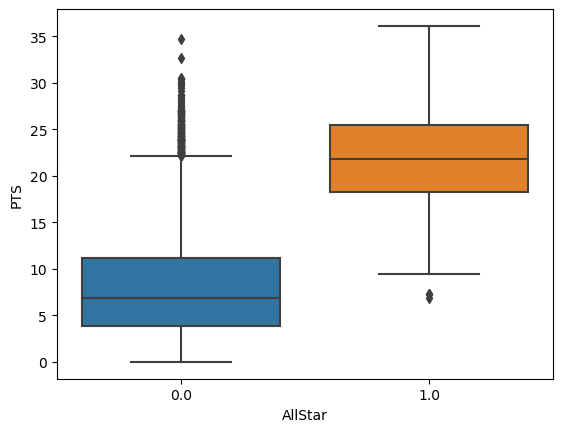

In [890]:
"""
We additionally create a quick boxplot of the distribution of the points per game statistic,
the arguably most important statistic for determining if a player will be selected for the All Star game,
as can also be seen in the above correlation matrix:
"""
sns.boxplot(data=player_stats, x="AllStar", y="PTS")

In [891]:
#divide main dataframe into training and testing datasets
df_train = player_stats[player_stats.season.between(2000, 2020)]
df_test = player_stats[player_stats.season.between(2021, 2023)]

# Part 2: All Star game predictions 

The goal of this section is, firstly, the prediction of the players selected for the All Star Game in the season contained in *df_test* and secondly, to analyse the performance of said prediction. Accordingly, the section can be divided into the following steps:
1. Definition of feature and target datasets
2. Training of models. The models used are:
    - Logistic Regression Classifier
    - XGBoost Classifier
    - Decision Tree Classifier
3. Brief visualisation of the feature importance for XGBoost and logistic regression.
4. Analysis and visualisation of model performance via standard classification metrics, namely F1 and AUC-ROC.
5. Same as above, but with a custom performance metric, where the players with highest likelihood as predicted by the model are selected and compared with the actual All Star Game selections.

**The main result is**: the best performing model is the logistic regression classifier, with an average AUC-Score of ~88% 


In [892]:
#create feature and target dataset
cols_allstar = [c for c in columns if c != 'AllStar']
X_allstar = df_train[cols_allstar]
y_allstar = df_train.AllStar.astype('int')

In [893]:
#initialize and train XGB Classifier
model_xgb_allstar = XGBClassifier().fit(X_allstar, y_allstar)

#Train Logistic Regression classifier
#model_log_mvp = LogisticRegression(solver='liblinear', C=1.0).fit(X, y_mvp)

#initialize and train Logistic Regression Classifier
model_log_allstar = LogisticRegression(solver='liblinear', C=1.0).fit(X_allstar, y_allstar)

# Train Decision Tree Classifer
#model_clf_mvp = DecisionTreeClassifier().fit(X,y_mvp)

#initialize and train Decision Tree Classifier
model_clf_allstar = DecisionTreeClassifier().fit(X_allstar,y_allstar)

<Axes: title={'center': 'Feature Importance of XGB Classifier'}>

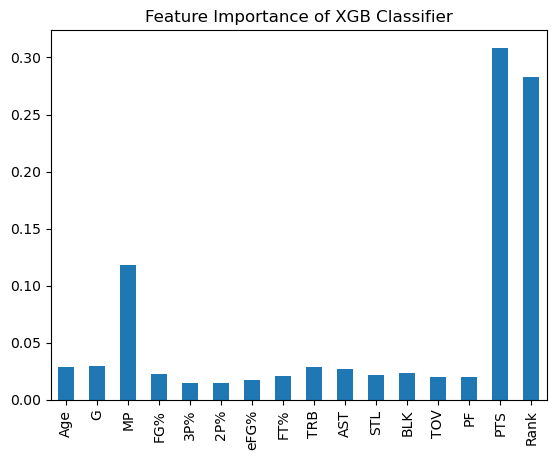

In [894]:
#generate quick plot of feature importance in XGBoost
pd.Series(
    model_xgb_allstar.feature_importances_,
    X_allstar.columns
    
).plot(kind='bar',title='Feature Importance of XGB Classifier')

<Axes: title={'center': 'Logistic Regression Classifier Coefficients'}>

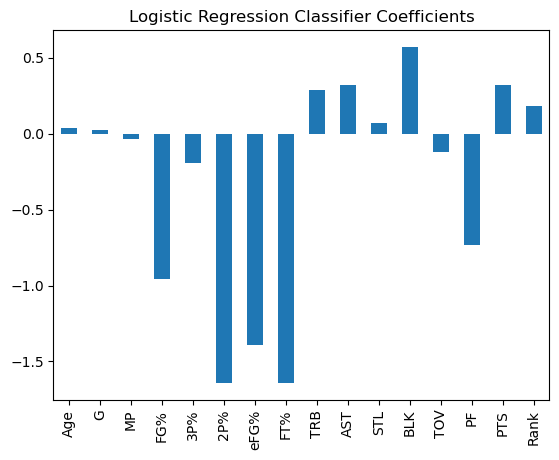

In [895]:
#Generate graph of Log. Reg. Coefficients
pd.Series(
    model_log_allstar.coef_[0],
    X_allstar.columns

).plot(kind='bar', title='Logistic Regression Classifier Coefficients')

In [896]:
""" 
In this cell we generate dataframes that contain the F1/AUC scores for all three models across the seasons in the testing dataset
"""

#create separeate dataframe for score evaluation and filter for pertinent years
df_score = df_test.copy()
df_score = df_score[df_score.season < 2024]

#generate predictions on testing set for all three models
df_score['Log_Prediction'] = model_xgb_allstar.predict(df_score[cols_allstar])
df_score['XGB_Prediction'] = model_log_allstar.predict(df_score[cols_allstar])
df_score['Tree_Prediction'] = model_clf_allstar.predict(df_score[cols_allstar])

#compute f1 score for each season
f1 = (
    df_score.groupby('season')
    .apply(lambda x: pd.Series({
        'F1_Log': f1_score(x['AllStar'], x['Log_Prediction']),
        'F1_XGB': f1_score(x['AllStar'], x['XGB_Prediction']),
        'F1_Tree': f1_score(x['AllStar'], x['Tree_Prediction'])
    }))
    .reset_index()
)

#compute total f1 score, i.e. accross all seasons
total_f1 = pd.Series({
    'F1_Log': f1_score(df_score['AllStar'], df_score['Log_Prediction']),
    'F1_XGB': f1_score(df_score['AllStar'], df_score['XGB_Prediction']),
    'F1_Tree': f1_score(df_score['AllStar'], df_score['Tree_Prediction'])
})

#join f1 and f1_total together, in order to have all information in one dataframe
f1_total = pd.concat([
    f1,
    pd.DataFrame([['Total', *total_f1.values]], columns=f1.columns)
])

#compute AUC score for each season
auc = (
    df_score.groupby('season')
    .apply(lambda x: pd.Series({
        'AUC_Log': roc_auc_score(x['AllStar'], x['Log_Prediction']),
        'AUC_XGB': roc_auc_score(x['AllStar'], x['XGB_Prediction']),
        'AUC_Tree': roc_auc_score(x['AllStar'], x['Tree_Prediction'])
    }))
    .reset_index()
)

#compute total AUC score, i.e. accross all seasons
total_auc = pd.Series({
    'AUC_Log': roc_auc_score(df_score['AllStar'], df_score['Log_Prediction']),
    'AUC_XGB': roc_auc_score(df_score['AllStar'], df_score['XGB_Prediction']),
    'AUC_Tree': roc_auc_score(df_score['AllStar'], df_score['Tree_Prediction'])
})

#join auc and auc_total together, in order to have all information in one dataframe
auc_total = pd.concat([
    auc,
    pd.DataFrame([['Total', *total_auc.values]], columns=auc.columns)
])

In [897]:
#plotting of the above dataframes is carried out by this function
def score_evolution_plot(df_data, column_list, label):
    """
    Args:
        df_data: dataframe containing model performance score data
        column_list: names for items of y-axis
        label: title for the graph

    Returns:
        A bar graph of the model scores

    """
    x_axis = df_data.season.astype(str)

    fig = go.Figure(data=[
    go.Bar(name='Log Regression', x=x_axis, y=df_data[column_list[0]], marker_color='pink'),
    go.Bar(name='XGB Classifier', x=x_axis, y=df_data[column_list[1]], marker_color='chocolate'),
    go.Bar(name='Decision Tree', x=x_axis, y=df_data[column_list[2]], marker_color='burlywood')
    
    ])

    fig.update_layout(
        barmode='group',
        title=label
    )
    
    fig.show()

In [898]:
#plot evolution of scores for the F1 and AUC metrics
score_evolution_plot(f1_total, ['F1_Log', 'F1_XGB', 'F1_Tree'], 'F1 Score Evolution')
score_evolution_plot(auc_total, ['AUC_Log', 'AUC_XGB', 'AUC_Tree'], 'AUC Score Evolution')

In [899]:
"""
We now aim to validate the performance of all three models through a custom metric. 
The metrics consists in taking 24 players with highest likelihood of being part of the All Star game for each season, as predicted by the model.
In the next step, we check how many of these players were actually part of the All Star game.
Afterwards, the results are plotted, making use of our plotting function.
"""

#create separeate dataframe for score evaluation and filter for pertinent years
df_score = df_test.copy()

#predict probabilities for All Star game appeareance for each player for each model
df_score['Log_Prediction'] = model_xgb_allstar.predict_proba(df_score[cols_allstar])[:,1]
df_score['XGB_Prediction'] = model_log_allstar.predict_proba(df_score[cols_allstar])[:,1]
df_score['Tree_Prediction'] = model_clf_allstar.predict_proba(df_score[cols_allstar])[:,1]

#modify dataframe so that for any player the prediction of each model is in a separate line 
df_long = df_score.melt(
    id_vars = ['season', 'playerName', 'AllStar'],
    value_vars = ['Log_Prediction', 'XGB_Prediction', 'Tree_Prediction'],
    var_name='Model',
    value_name='Prediction'
)

#group by season and model and only keep 24 player with highest probability
top_preds = (
    df_long
        .sort_values(by=['season', 'Model', 'Prediction'], ascending=[True, True, False])
        .groupby(by=['season', 'Model'])
        .head(24)
)

#counts number of allstar for each season
allstars = df_test.groupby(by='season')['AllStar'].sum()

#create dataframe containing the percentage of correctly predicted All Star game players for each season, for each model 
correct = (
    top_preds
        .groupby(by=['season', 'Model'])['AllStar'].sum()
        .reset_index(name="Correct")
        .merge(allstars, on="season")
        .assign(pct=lambda x : x.Correct / x.AllStar)
        .pivot(index='season', columns='Model', values='pct')
        .reset_index()
)

correct

Model,season,Log_Prediction,Tree_Prediction,XGB_Prediction
0,2021.0,0.777778,0.611111,0.777778
1,2022.0,0.772727,0.545455,0.681818
2,2023.0,0.714286,0.666667,0.857143


In [900]:
#plot the results
score_evolution_plot(correct, ['Log_Prediction', 'XGB_Prediction', 'Tree_Prediction'], 'Accuracy Score Evolution')

# Part 2: NBA MVP predictions 

We now aim to predict the NBA MVP for the seasons 2021 through 2023. To make the prediction, multiple modeling strategies were made use of, these being:
- Treating the problem as a classification problem with classes *0* and *1* in the column *Rank*. The models employed for this were the naive Bayes and the random forest classifiers. 
- Approaching the prediction through a regression model by allowing all possible values in the column *Rank*.

Throughout the following section, the algortithm *GridSearchCV* was employed to find appropiate model parameters. To avoid performance issues, we also used *RandomizedSearchCV*. 

Furthermore, in the regression approach, we made use the standard data scaling routine available in the *sklearn* library.

In [901]:
#define feature and target datasets
cols_mvp = [c for c in columns if c != 'Rank']

#for the classification approach, we limit the column Rank to two classes, MVP and non-MVP
X_mvp_clf = df_train.loc[df_train.Rank.isin([0,1]), cols_mvp]
y_mvp_clf = df_train.loc[df_train.Rank.isin([0,1]),'Rank'].astype('int')

#for the regression approach, we leave df_train untouched, only limiting columns
X_mvp_reg = df_train[cols_mvp]
y_mvp_reg = df_train.Rank.astype('int')

## Part 2.1: Classification Approach

As mentioned above, the contents of this section are:
- A modeling with naive Bayes. The results are, however, unsatisfactory, as the number of false positives is quite large, as indicated by the recall score,
- A modeling with a random forest classifier. The model is able to predict the NBA MVP two out of three times, but also wrongly marks to addtional players as MVP.
- As the random forest classifier showed somewhat promising results, we aim to optimize the model parameters via the *GridSearchCV* algorithm. The result is a significant improvement of the model, resulting in merely one false positive and one false negative. 

In [ ]:
df_score = df_test.loc[df_test.Rank.isin([0,1])]

#fit naive Bayes
model_nb = GaussianNB().fit(X_mvp_clf, y_mvp_clf)

#make predictions on test set
y_pred = model_nb.predict(df_score[cols_mvp])

#compute key metrics
accuracy = accuracy_score(df_score['Rank'], y_pred)
precision = precision_score(df_score['Rank'], y_pred)
recall = recall_score(df_score['Rank'], y_pred)
f1 = f1_score(df_score['Rank'], y_pred)

#print results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


Accuracy: 0.976
Precision: 0.079
Recall: 1.000
F1 Score: 0.146


In [ ]:
#show player predictions
df_test_clf = df_test[df_test.Rank.isin([0,1])]
df_test_clf.loc[:,['NB_pred']] = y_pred
#as number of false positives is quite large, we limit the number of rows to 10
df_test_clf[(df_test_clf.Rank == 1) | (df_test_clf.NB_pred == 1)].head(10)

,playerName,season,Age,team,G,MP,FG%,3P%,2P%,eFG%,...,TRB,AST,STL,BLK,TOV,PF,PTS,Rank,AllStar,NB_pred
8016,LeBron James,2021.0,36.0,LAL,45.0,33.4,0.513,0.365,0.591,0.576,...,7.7,7.8,1.1,0.6,3.7,1.6,25.0,0,1.0,1
8017,Paul George,2021.0,30.0,LAC,54.0,33.7,0.467,0.411,0.510,0.557,...,6.6,5.2,1.1,0.4,3.3,2.4,23.3,0,1.0,1
8018,Mike Conley,2021.0,33.0,UTA,51.0,29.4,0.444,0.412,0.479,0.552,...,3.5,6.0,1.4,0.2,1.9,1.9,16.2,0,1.0,1
8020,Kawhi Leonard,2021.0,29.0,LAC,52.0,34.1,0.512,0.398,0.557,0.568,...,6.5,5.2,1.6,0.4,2.0,1.6,24.8,0,1.0,1
8033,Nikola Jokic,2021.0,25.0,DEN,72.0,34.6,0.566,0.388,0.606,0.602,...,10.8,8.3,1.3,0.7,3.1,2.7,26.4,1,1.0,1


In [ ]:
#fit random forest
clf = RandomForestClassifier(max_depth=10)
clf.fit(X_mvp_clf, y_mvp_clf)

#make predictions on test set
y_pred = clf.predict(df_score[cols_mvp])

#compute key metrics
accuracy = accuracy_score(df_score['Rank'], y_pred)
precision = precision_score(df_score['Rank'], y_pred)
recall = recall_score(df_score['Rank'], y_pred)
f1 = f1_score(df_score['Rank'], y_pred)

#print results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.998
Precision: 0.500
Recall: 0.667
F1 Score: 0.571


In [ ]:
#show player predictions
df_test_clf = df_test[df_test.Rank.isin([0,1])]
df_test_clf.loc[:,['RFclf_pred']] = y_pred
df_test_clf[(df_test_clf.Rank == 1) | (df_test_clf.RFclf_pred == 1)]

,playerName,season,Age,team,G,MP,FG%,3P%,2P%,eFG%,...,TRB,AST,STL,BLK,TOV,PF,PTS,Rank,AllStar,RFclf_pred
8033,Nikola Jokic,2021.0,25.0,DEN,72.0,34.6,0.566,0.388,0.606,0.602,...,10.8,8.3,1.3,0.7,3.1,2.7,26.4,1,1.0,0
8499,LeBron James,2022.0,37.0,LAL,56.0,37.2,0.524,0.359,0.620,0.590,...,8.2,6.2,1.3,1.1,3.5,2.2,30.3,0,1.0,1
8521,Nikola Jokic,2022.0,26.0,DEN,74.0,33.5,0.583,0.337,0.652,0.620,...,13.8,7.9,1.5,0.9,3.8,2.6,27.1,1,1.0,1
9044,Damian Lillard,2023.0,32.0,POR,58.0,36.3,0.463,0.371,0.574,0.564,...,4.8,7.3,0.9,0.3,3.3,1.9,32.2,0,1.0,1
9062,Joel Embiid,2023.0,28.0,PHI,66.0,34.6,0.548,0.330,0.587,0.573,...,10.2,4.2,1.0,1.7,3.4,3.1,33.1,1,1.0,1


In [ ]:
#perform parameter optimization for random forest classifier
clf = GridSearchCV(
    RandomForestClassifier(class_weight='balanced'), 
    param_grid= {
        'n_estimators' : [200, 300],
        'max_depth' : [3,10,20],
        'min_samples_leaf' : [10,15,20],
    },
    scoring='f1',
    cv = RepeatedKFold(n_splits=5),
    verbose=2,
    n_jobs=-1
)

In [ ]:
#fit optimized RF model
clf.fit(X_mvp_clf, y_mvp_clf)

#make predictions on test set
y_pred = clf.predict(df_score[cols_mvp])

#compute key metrics
accuracy = accuracy_score(df_score['Rank'], y_pred)
precision = precision_score(df_score['Rank'], y_pred)
recall = recall_score(df_score['Rank'], y_pred)
f1 = f1_score(df_score['Rank'], y_pred)

#print results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.999
Precision: 0.667
Recall: 0.667
F1 Score: 0.667


In [ ]:
#show player predictions
df_test_clf = df_test[df_test.Rank.isin([0,1])]
df_test_clf.loc[:,['Opt_RFclf_pred']] = y_pred
df_test_clf[(df_test_clf.Rank == 1) | (df_test_clf.Opt_RFclf_pred == 1)]

,playerName,season,Age,team,G,MP,FG%,3P%,2P%,eFG%,...,TRB,AST,STL,BLK,TOV,PF,PTS,Rank,AllStar,Opt_RFclf_pred
8033,Nikola Jokic,2021.0,25.0,DEN,72.0,34.6,0.566,0.388,0.606,0.602,...,10.8,8.3,1.3,0.7,3.1,2.7,26.4,1,1.0,0
8499,LeBron James,2022.0,37.0,LAL,56.0,37.2,0.524,0.359,0.620,0.590,...,8.2,6.2,1.3,1.1,3.5,2.2,30.3,0,1.0,1
8521,Nikola Jokic,2022.0,26.0,DEN,74.0,33.5,0.583,0.337,0.652,0.620,...,13.8,7.9,1.5,0.9,3.8,2.6,27.1,1,1.0,1
9062,Joel Embiid,2023.0,28.0,PHI,66.0,34.6,0.548,0.330,0.587,0.573,...,10.2,4.2,1.0,1.7,3.4,3.1,33.1,1,1.0,1


## Part 2.2: Regression Approach

In an effort to further improve the results delivered by using a classification approach, in the following section the predictions will be made with a regression model. To also improve model performance, we try to mitigate the inbalance between the *MVP* and *Non-MVP* classes by allowing all values in the *Rank* column.

The chosen model for this task is XGBoost. The model however fails to make correct prediction of the MVP voting Rank, thus showing that the classification approach to this problem provides sigficantly better results. 

A possible approach for improving results would be to include more statistics relevant to the MVP voting, such as wins of each team or win-shares of each player. 

In [ ]:
#perform parameter optimization for XGBoost regressor
clf = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror',n_estimators=100), 
    param_distributions= {
        'subsample' : [0.5, 0.25],
        'max_depth' : [3,6,10],
        'learning_rate' : [0.05,0.1],
    },
    scoring='r2',
    cv = RepeatedKFold(n_splits=5),
    verbose=2,
    n_jobs=-1
)

#fit model
clf.fit(X_mvp_reg, y_mvp_reg)

Fitting 50 folds for each of 10 candidates, totalling 500 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 6, 10],
                                        'subsample': [0.5, 0.25]},
                   scoring='r2', verbose=2)

In [ ]:
#make predictions on test set
y_pred = clf.predict(df_test[cols_mvp])

#calculate metrics
mse = mean_squared_error(df_test['Rank'], y_pred)
r2 = r2_score(df_test['Rank'], y_pred)

#print results
print(f"MSE: {mse:.3f}")
print(f"R2 Score: {r2:.3f}")

MSE: 0.718
R2 Score: 0.208


In [ ]:
#show top player predictions
df_test.loc[:,'XGB_pred'] = y_pred
df_test.loc[:,'XGB_pred_rank'] = df_test.groupby(by='season')['XGB_pred'].rank(ascending=False, method='first')
(df_test[df_test['XGB_pred_rank'].isin([1,2,3])]
    .sort_values(by=['season', 'XGB_pred_rank'])
    .loc[:,['playerName', 'season', 'Rank', 'XGB_pred_rank']]
)

,playerName,season,Rank,XGB_pred_rank
8033,Nikola Jokic,2021.0,1,1.0
8027,Damian Lillard,2021.0,7,2.0
8020,Kawhi Leonard,2021.0,0,3.0
8534,DeMar DeRozan,2022.0,0,1.0
8495,Stephen Curry,2022.0,8,2.0
8514,Karl-Anthony Towns,2022.0,0,3.0
9115,Lauri Markkanen,2023.0,0,1.0
9091,Domantas Sabonis,2023.0,7,2.0
9080,DeMar DeRozan,2023.0,0,3.0
